## Code

In [1]:
from scipy.special import kl_div
import numpy as np
from tqdm import tqdm
from operator import xor
import numpy as np

def xor(a, b):
    """Return true if only one of a or b is true"""
    return a!=b

def bin_data(test_values, ref_values, n_bins, bins_x, bins_y):
    """Create binned estimates of density, maybe on the GPU."""
    
    # safety checks to make sure either 
    assert (bins_x is not None)==(bins_y is not None), (
        'bins_x and bins_y must either both be set or neither set'
    )
    assert xor(
        (n_bins is not None),  
        ((bins_x is not None) and (bins_y is not None))
    ), "either n_bins or (bins_x and bins_y) must be set, not both"
        
    def check_data_within_bins(arr, bins, prefix):
        assert arr.min()>= bins.min(), f"{prefix} bin: array value {arr.min()} less than bin min {bins.min()}"
        assert arr.max()<=bins.max(), f"{prefix} bin: array value {arr.max()} more than bin max {bins.max()}"

    def hist(x, y):        
        assert len(x)==len(y)
        n = len(x)
        
        if (bins_x is not None) and (bins_y is not None):
            check_data_within_bins(x, bins_x, 'x')
            check_data_within_bins(y, bins_y, 'y')
            result = np.histogram2d(x, y, bins=[bins_x, bins_y], density=False)
        else:
            result = np.histogram2d(
                x, y, 
                bins=n_bins, 
                range=[[xmin, xmax], [ymin, ymax]], 
                density=False
            )
        
        result = result[0].flatten()/n
        return result
    
    # create bins:
    if n_bins is not None:
        xmax = max([values[0].max() for values in [test_values, test_values]])
        ymax = max([values[1].max() for values in [test_values, test_values]])
        
        xmin = min([values[0].min() for values in [test_values, test_values]])
        ymin = min([values[1].min() for values in [test_values, test_values]])
    
    p = hist(*test_values)
    q = hist(*ref_values)
    
    return p, q


def est_js_div(test_values, ref_values, n_bins=None, bins_x=None, bins_y=None):
    """Empirically estimate the JS-divergence.
    
    You can either pass in x and y bins or select a number of bins, n_bins.
    If you select a number of bins is used it creates equally spaced bins.
    """
    p, q = bin_data(test_values, ref_values, n_bins, bins_x, bins_y)    
    m = (p+q)/2
    div = (kl_div(p, m) + kl_div(q, m)).sum()/2
    return div


def bootstrap_sample(x):
    n = len(x[0])
    inds = np.random.randint(0, n, n)
    return [a[inds] for a in x]
    
def js_value_and_bootstrap_results(test_values, ref_values, n_bins=None, bins_x=None, bins_y=None):
    """Calculates the JS-divergence value and the 5, 50 and 95% bootstrap values."""
    value = est_js_div(test_values, ref_values, n_bins, bins_x, bins_y)
    bootstrap_values = []
    for n in tqdm(range(200)):
        x_ref = bootstrap_sample(ref_values)
        x_test = bootstrap_sample(test_values)
        div = est_js_div(x_test, x_ref, n_bins, bins_x, bins_y)
        bootstrap_values += [div]
    return value, np.quantile(bootstrap_values, [0.05, 0.5, 0.95])

## Demo

The test and reference data should each be a list of two arrays like
```
ref_values = [ref_temperatures, ref_precipitations]
test_values = [ref_temperatures, ref_precipitations]
```

In [2]:
ref_values = [np.array([1,2,3,4,5,6,7]), np.array([.1,.2,.3,.4,.5,.6,.7])]
test_values = [np.array([-1,2,3,3,4,6,6]), np.array([.0,.2,.2,.4,.5,.6,.9])]

You can either select the number of bins for each dimension to be split up into. 

If you do this will create equally spaced bins in each dimension like:

In [3]:
np.linspace(
    min(min(ref_values[0]), min(test_values[0])), 
    max(max(ref_values[0]), max(test_values[0])), 
    10,
)

array([-1.        , -0.11111111,  0.77777778,  1.66666667,  2.55555556,
        3.44444444,  4.33333333,  5.22222222,  6.11111111,  7.        ])

and 

In [4]:
np.linspace(
    min(min(ref_values[1]), min(test_values[1])), 
    max(max(ref_values[1]), max(test_values[1])), 
    10,
)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

This is the way I have been doing mine and I just use 30 bins.

Otherwise you can specify the bins if you want. They need to be numpy arrays, and all data needs to lie within them

In [5]:
est_js_div(ref_values, test_values, bins_x=np.array([-2, -1, 0, 5, 10]), bins_y=np.array([0, .5, 1]))

0.11133181856354647

This one won't work because the min value of the x bin is too high. There are lower values than it in x

In [6]:
est_js_div(ref_values, test_values, bins_x=np.array([0, 5, 10]), bins_y=np.array([0, .5, 1]))

AssertionError: x bin: array value -1 less than bin min 0

Here is a random example

In [7]:
N = 12000
ref_values = [np.random.normal(0, 1, N), np.random.normal(0, 1, N)]
test_values = [np.random.normal(0, 1, N), np.random.normal(0, 1, N)]

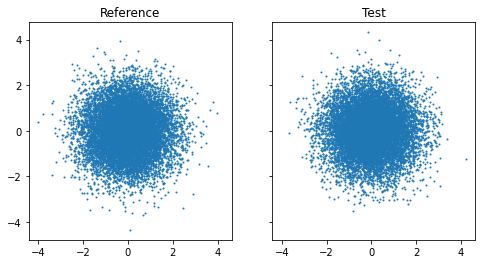

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
axes[0].scatter(*ref_values, s=1)
axes[1].scatter(*test_values, s=1)
axes[0].set_title("Reference")
axes[1].set_title("Test")
plt.show()

In [25]:
est_js_div(ref_values, test_values, n_bins=30)

0.013107247240485818

In [26]:
est_js_div(ref_values, test_values, n_bins=10)

0.0022804259676356296

And again with specified bins

In [27]:
bins_x = np.array([-100, -1,0,1,100])
bins_y = np.array([-10,-6, -2,-1,0,1, 2, 6, 10])

est_js_div(ref_values, test_values, bins_x=bins_x, bins_y=bins_y)

0.0004412536396389752

This calculates the normal value and the 5, 50 and 95% using the bootstrap method. Again you can specify the number of bins or the actual bins

In [28]:
js_value_and_bootstrap_results(ref_values, test_values, n_bins=30)

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 301.76it/s]


(0.013107247240485818, array([0.02110447, 0.02348341, 0.0266379 ]))

In [29]:
js_value_and_bootstrap_results(ref_values, test_values, bins_x=bins_x, bins_y=bins_y)

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 380.70it/s]


(0.0004412536396389752, array([0.00056822, 0.00087059, 0.00136714]))

We could probably do something more clever with the bin spacing like use percetile bins like below, but really I don't want to have to go back through and make that divergence map again. So cba. Also based on below its not very good.

In [30]:
def quantile_bins(x1, x2, bins=10):
    """Creates bins so that there should be an even percentage of data in each one.
    
    This will kind of break down since we are doing it in 2D but wevs."""
    quantiles = np.linspace(0, 1, bins+1)
    return np.quantile(np.concatenate([x1, x2]), quantiles)

bins_x = quantile_bins(test_values[0], ref_values[0], 10)
print(bins_x)
bins_y = quantile_bins(test_values[1], ref_values[1], 10)


js_value_and_bootstrap_results(ref_values, test_values, bins_x=bins_x, bins_y=bins_y)

[-4.00470308 -1.29960322 -0.85342535 -0.53815298 -0.26252624 -0.01698001
  0.23914115  0.50365956  0.81826608  1.27414853  4.22738628]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 395.71it/s]


(0.0025824473984606584, array([0.00380115, 0.00468472, 0.00574499]))

What does a bootstrap look like?

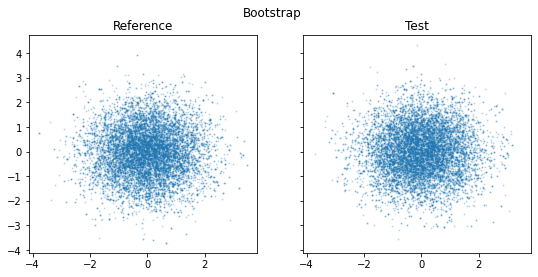

In [42]:
fig, axes = plt.subplots(1,2, figsize=(9, 4), sharex=True, sharey=True)
axes[0].scatter(*bootstrap_sample(ref_values), s=1, alpha=.2)
axes[1].scatter(*bootstrap_sample(test_values), s=1,  alpha=.2)
axes[0].set_title("Reference")
axes[1].set_title("Test")
plt.suptitle("Bootstrap")
plt.show()

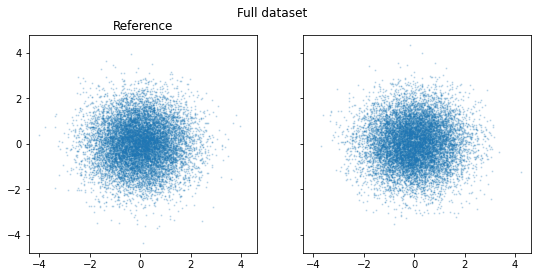

In [43]:
fig, axes = plt.subplots(1,2, figsize=(9, 4), sharex=True, sharey=True)
axes[0].scatter(*ref_values, s=1, alpha=.2)
axes[1].scatter(*test_values, s=1, alpha=.2)
axes[0].set_title("Reference")
plt.suptitle("Full dataset")
plt.show()